### Amazon Cookbooks Topic Modeling Using Titles

#### Necessary Tools

In [33]:
import numpy as np
import pandas as pd
import re, string
#import contractions

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.cluster import KMeans

from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# --- Parser for reading in the Amazon json files (can be used for both reviews and metadata)
def parse(path):
    g = open(path, 'r')
    for l in g:
        yield json.loads(l)

VECTORIZATION = {
    'count': CountVectorizer,
    'tfidf': TfidfVectorizer
}

DIMENSIONALITY_REDUCTION = {
    'PCA': PCA,
    'LSA': TruncatedSVD,
    'NMF': NMF,
    'LDA': LatentDirichletAllocation
}

class nlp_model:
    """
    """
    
    def __init__(self, vect_method = "count", dim_reduc="LSA", n_components = 21):
        """
        """
        #self.doc_text = data
        
        # --- Tokens Vectorization Methods
        if vect_method == "tfidf":
            self.vect_method = vect_method
        else:
            self.vect_method = "count"
            
        # --- Dimensionality Reduction Methods
        if dim_reduc == "PCA" or dim_reduc == "NMF" or dim_reduc == "LDA":
            self.dim_reduc = dim_reduc
        else:
            self.dim_reduc = "LSA"
        
        # --- number of components for dimensionality reduction
        self.n_components = n_components
        
    def fit(self, data, save_fitX = False, filename = ""):
        self.doc_text = data
        
        vect_method =  VECTORIZATION[self.vect_method](stop_words='english')
        vect_data = vect_method.fit_transform(self.doc_text).toarray()
        
        dr_method = DIMENSIONALITY_REDUCTION[self.dim_reduc](n_components=self.n_components)
        self.doc_dr_data = dr_method.fit_transform(vect_data)

def plot_all_dimensions(data, class_labels, title=""):
    plt.rcParams['figure.figsize'] = [30, 20]
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        
        plt.subplot(2,3, count)
        plt.scatter(data[:,i], data[:,j],# ckbk_space[vect][dr][:,2],
                   s = 4, alpha = 0.5, c=class_labels)
        plt.title(title, fontsize=20, color='red')
        count += 1
    plt.show()

#### Clean Titles and Desciption

In [34]:
# --- Read cookbooks tables:  Products from meta_cookbooks.json and reviews from Cookbooks.json
ckbk_meta_file = "../data/amzn/meta_Cookbooks.json"
ckbk_reviews_file = "../data/amzn/Cookbooks.json"

ckbks = pd.read_json(ckbk_meta_file, lines=True)
#ckbks

# --- Clean descriptions and titles
ckbks["desc"] = ckbks["description"].apply(lambda x: " ".join(str(x).split()))
ckbks["desc_count"] = ckbks["description"].apply(lambda x: len(" ".join(x).split()))
#ckbks["rank_no"] = ckbks["rank"].apply(lambda x: int(str(x[:-8]).replace(",", "")))
#ckbks[ckbks["desc_count"] >= 20].describe()

In [35]:
ckbks["title_clean"] = ckbks["title"].apply(lambda x: " ".join(str(x).strip().split()))
ckbks["title_count"] = ckbks["title_clean"].apply(lambda x: len(" ".join(str(x)).strip().split()))

data = ckbks[["asin", "title", "title_clean", "desc"]].copy()

alphanumeric = lambda x: re.sub('[\d]+', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
data['title_clean'] = data['title_clean'].map(punc_lower)
data['title_clean'] = data['title_clean'].map(alphanumeric)
data['title_count'] = data['title_clean'].apply(lambda x: len(list(x.strip().split())))
#print(f"The size of the processed data: {data.shape}")
#data.head()
data.describe()
#data
#data[data['title_count']>50]
indx_to_drop = data[data['title_count']>50].index
data.drop(indx_to_drop, inplace=True)
data[data['title_count']>50]

Empty DataFrame
Columns: [asin, title, title_clean, desc, title_count]
Index: []

In [8]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

ckbk_space = {}

for vect in vect_methods:
    ckbk_space[vect]={}
    for dr in dim_reduc[:-1]:
        print(f"Running NLP on cookbooks using {vect} token vectorization and {dr} dimensionality reduction...")
        model = nlp_model(vect_method = vect, dim_reduc=dr, n_components = 5)
        model.fit(data['title_clean'])
        ckbk_space[vect][dr] = model.doc_dr_data
dump(ckbk_space, "../model/6models-noUnsup_08Nov19.joblib")

Running NLP on cookbooks using count token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and NMF dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and NMF dimensionality reduction...


['../model/6models-noUnsup_08Nov19.joblib']

In [3]:
ckbk_space = load("../model/6models-noUnsup_08Nov19.joblib")

In [5]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

count =1
plt.rcParams['figure.figsize'] = [30, 20]
for vect in vect_methods:
    for dr in dim_reduc[:-1]:
        plt.subplot(2,3, count)
        plt.scatter(ckbk_space[vect][dr][:,0], ckbk_space[vect][dr][:,1])
        plt.title(f"{vect} and {dr}", fontsize=20, color='red')
        count += 1
plt.show()

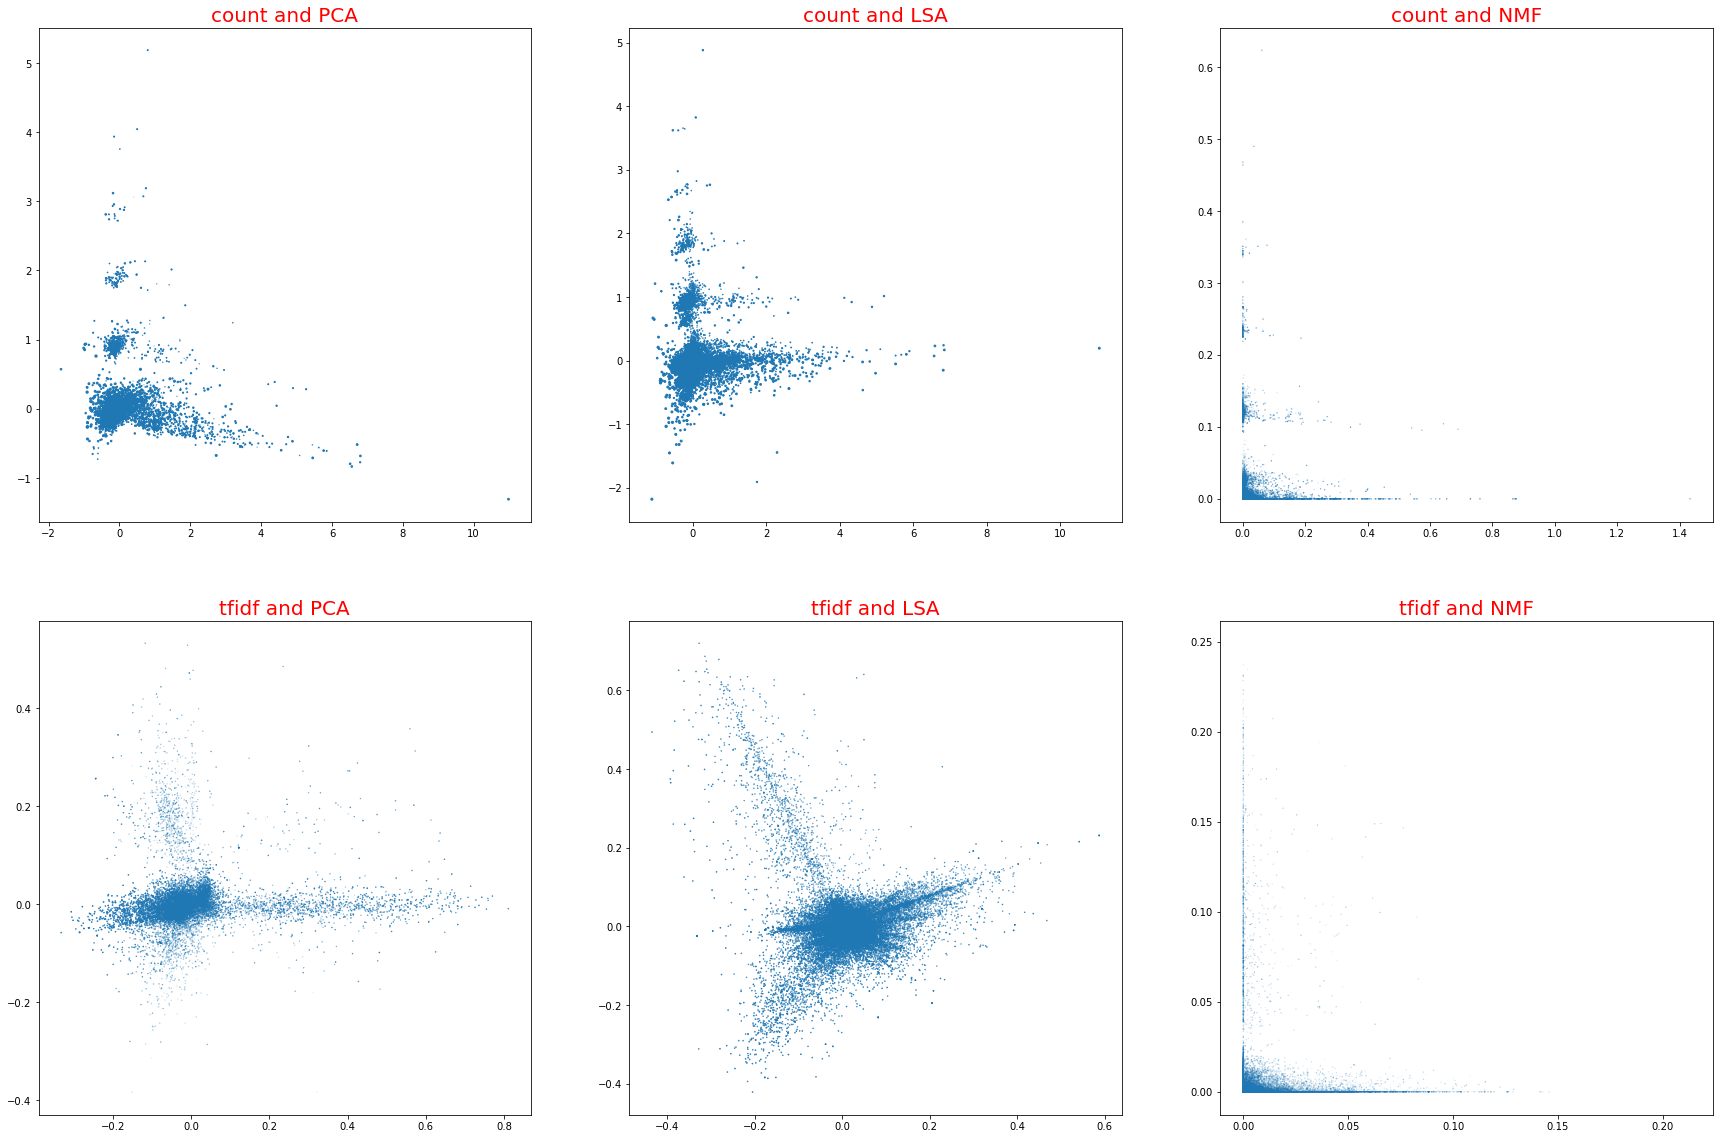

In [9]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

count =1
plt.rcParams['figure.figsize'] = [30, 20]
for vect in vect_methods:
    for dr in dim_reduc[:-1]:
        plt.subplot(2,3, count)
        plt.scatter(ckbk_space[vect][dr][:,3], ckbk_space[vect][dr][:,4], ckbk_space[vect][dr][:,0])
        plt.title(f"{vect} and {dr}", fontsize=20, color='red')
        count += 1
plt.show()

In [94]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(count_nmf2[:,0], count_nmf2[:,1], alpha = 0.5)
plt.title(f"Count and NMF", fontsize=10, color='red')
plt.show()

In [11]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

kmeans_titles = {}
for vect in vect_methods:
    kmeans_titles[vect] = {}
    for dr in dim_reduc[:-1]:
        kmeans = KMeans(n_clusters=10, random_state=30).fit(ckbk_space[vect][dr])
        kmeans_titles[vect][dr] = kmeans.labels_
        
#plt.rcParams['figure.figsize'] = [10, 10]

#plt.scatter(count_nmf2[:,0], count_nmf2[:,1], alpha = 0.5, c=count_nmf2_kmeans)# cmap=colors)
#plt.title(f"Count and NMF", fontsize=10, color='red')
#plt.show()

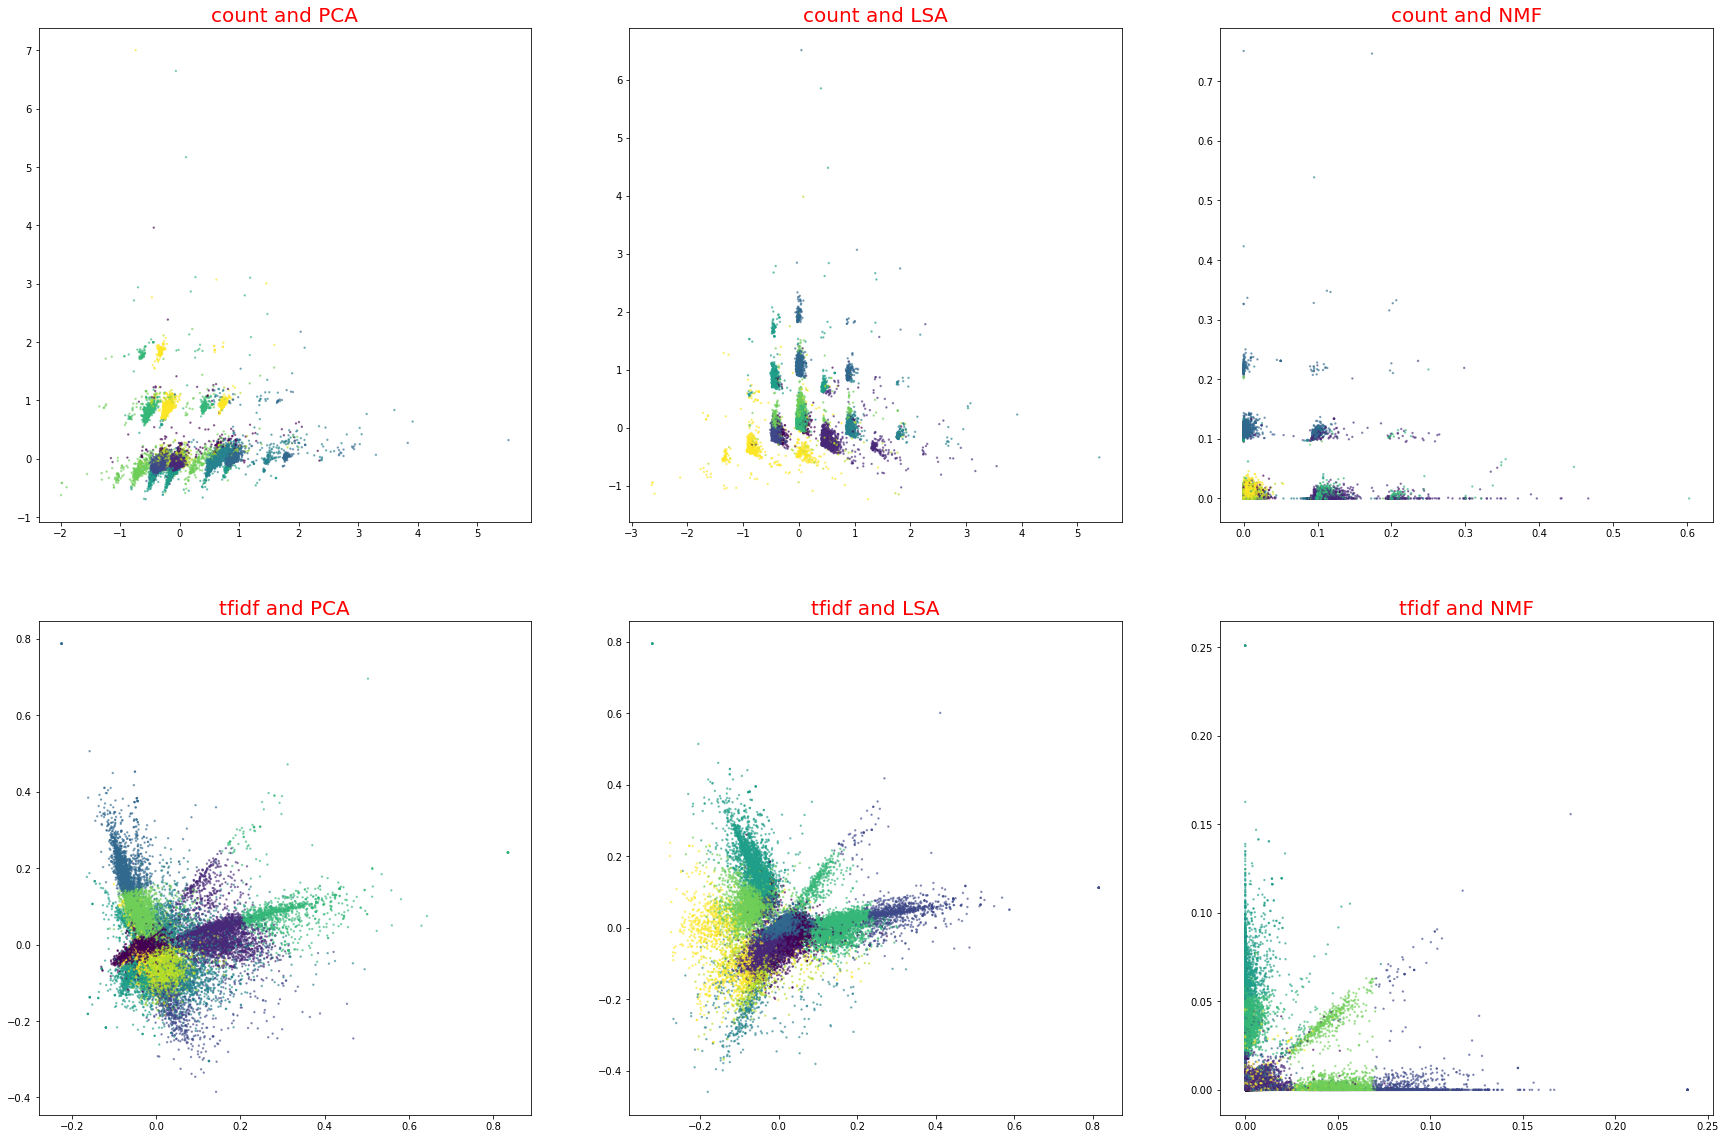

In [16]:
count =1
plt.rcParams['figure.figsize'] = [30, 20]
for vect in vect_methods:
    for dr in dim_reduc[:-1]:
        plt.subplot(2,3, count)
        plt.scatter(ckbk_space[vect][dr][:,1], ckbk_space[vect][dr][:,2],# ckbk_space[vect][dr][:,2],
                   s = 2, alpha = 0.5, c=kmeans_titles[vect][dr])
        plt.title(f"{vect} and {dr}", fontsize=20, color='red')
        count += 1
plt.show()

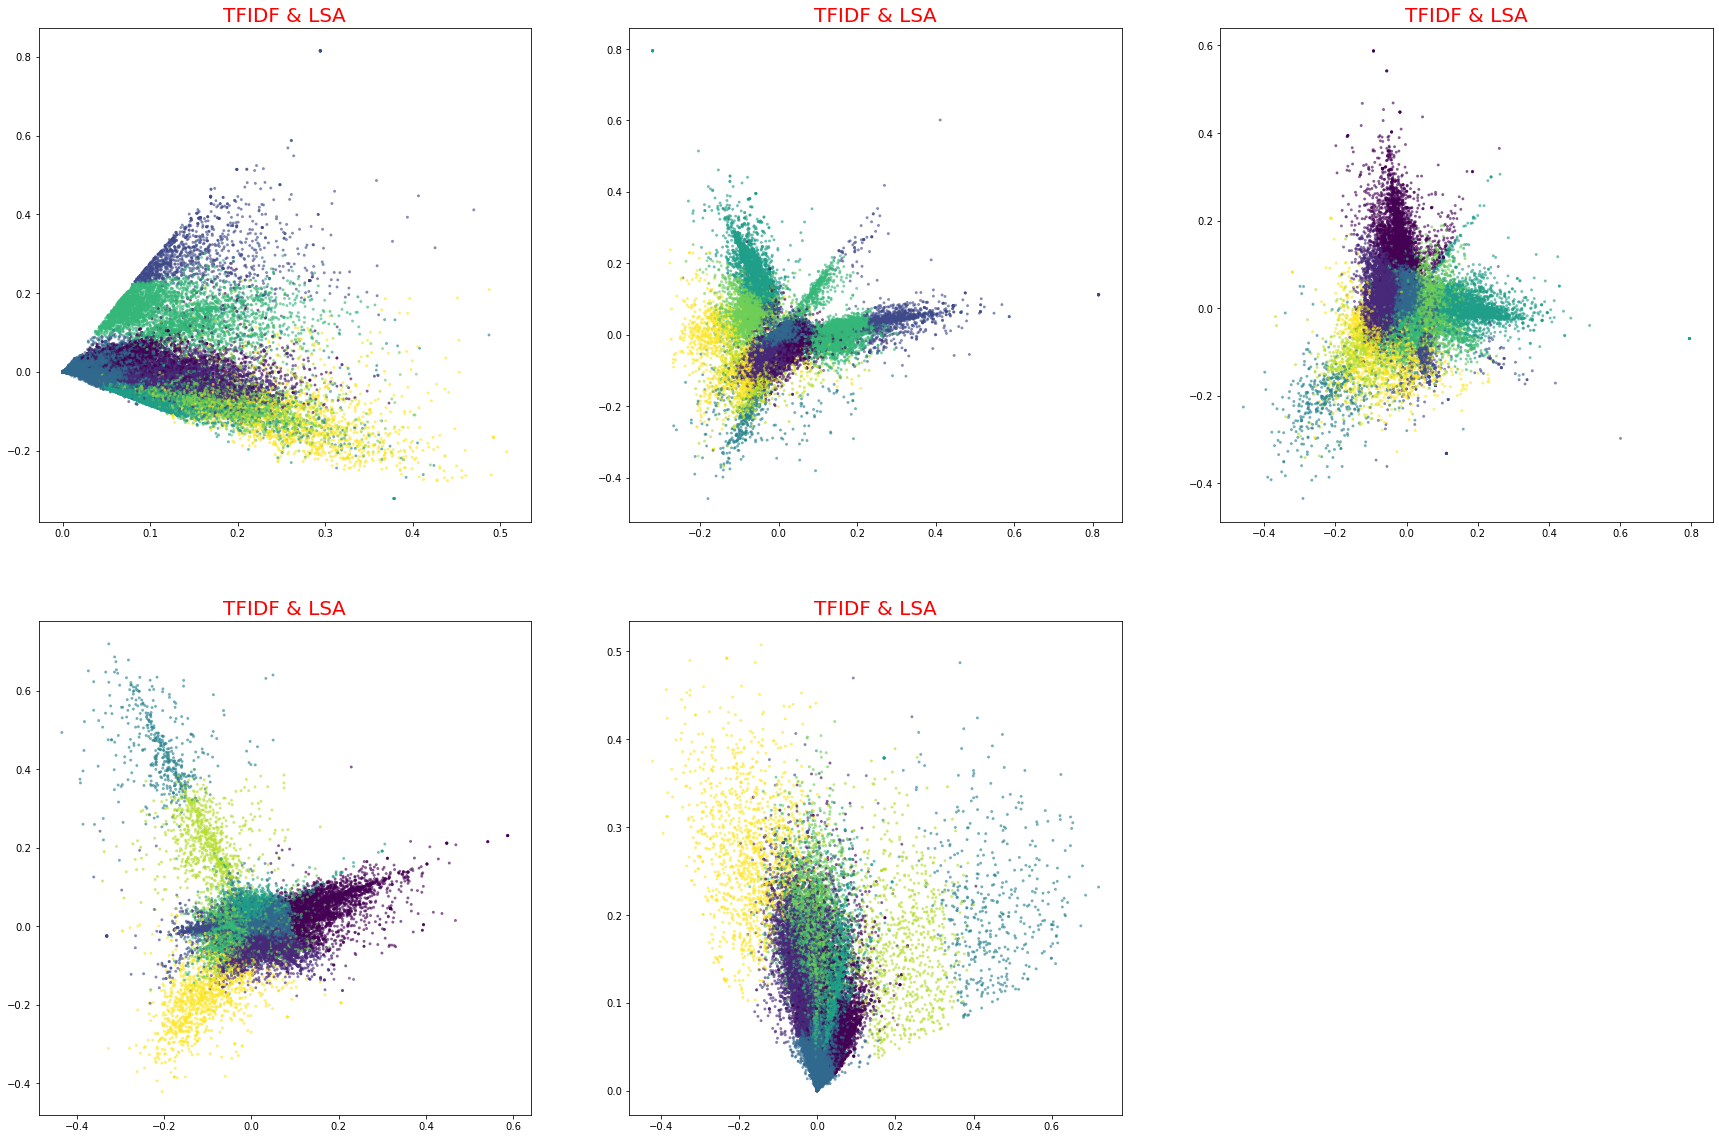

In [30]:
plot_all_dimensions(ckbk_space['tfidf']['LSA'], kmeans_titles['tfidf']['LSA'], "TFIDF & LSA")

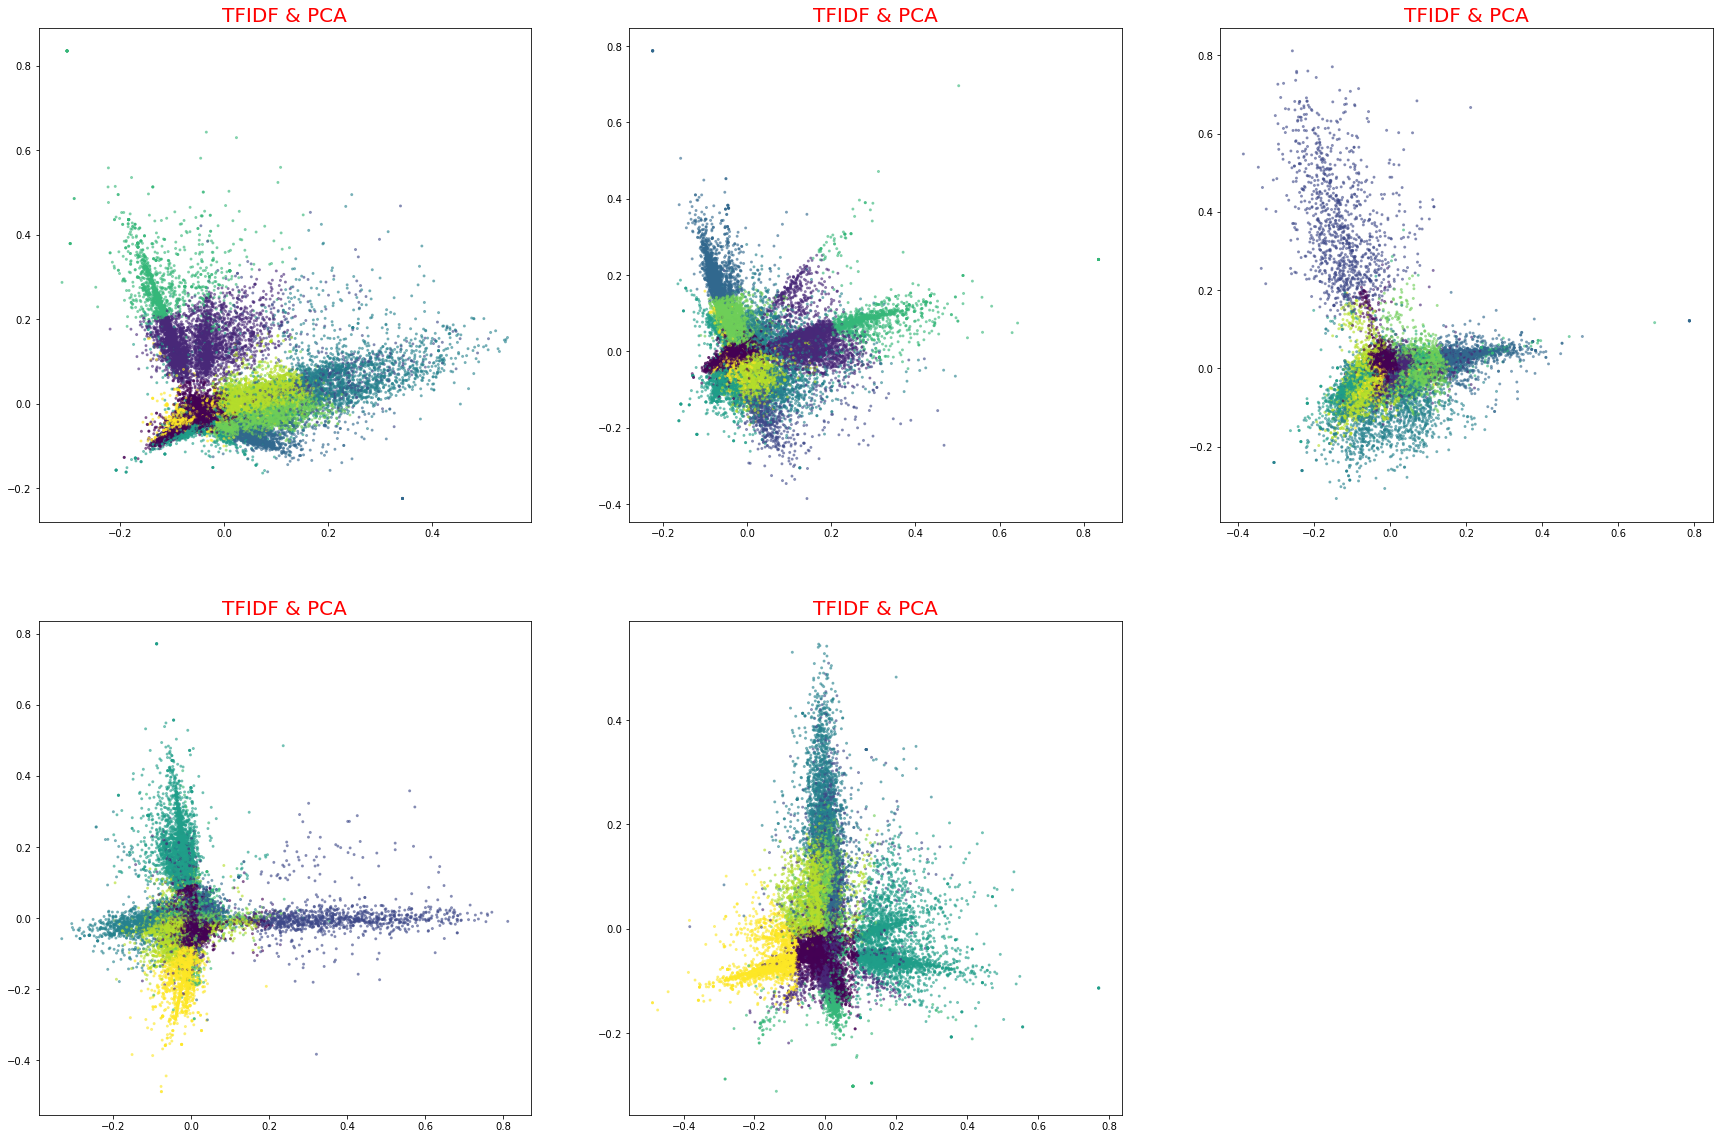

In [24]:
plot_all_dimensions(ckbk_space['tfidf']['PCA'], kmeans_titles['tfidf']['PCA'], "TFIDF & PCA")

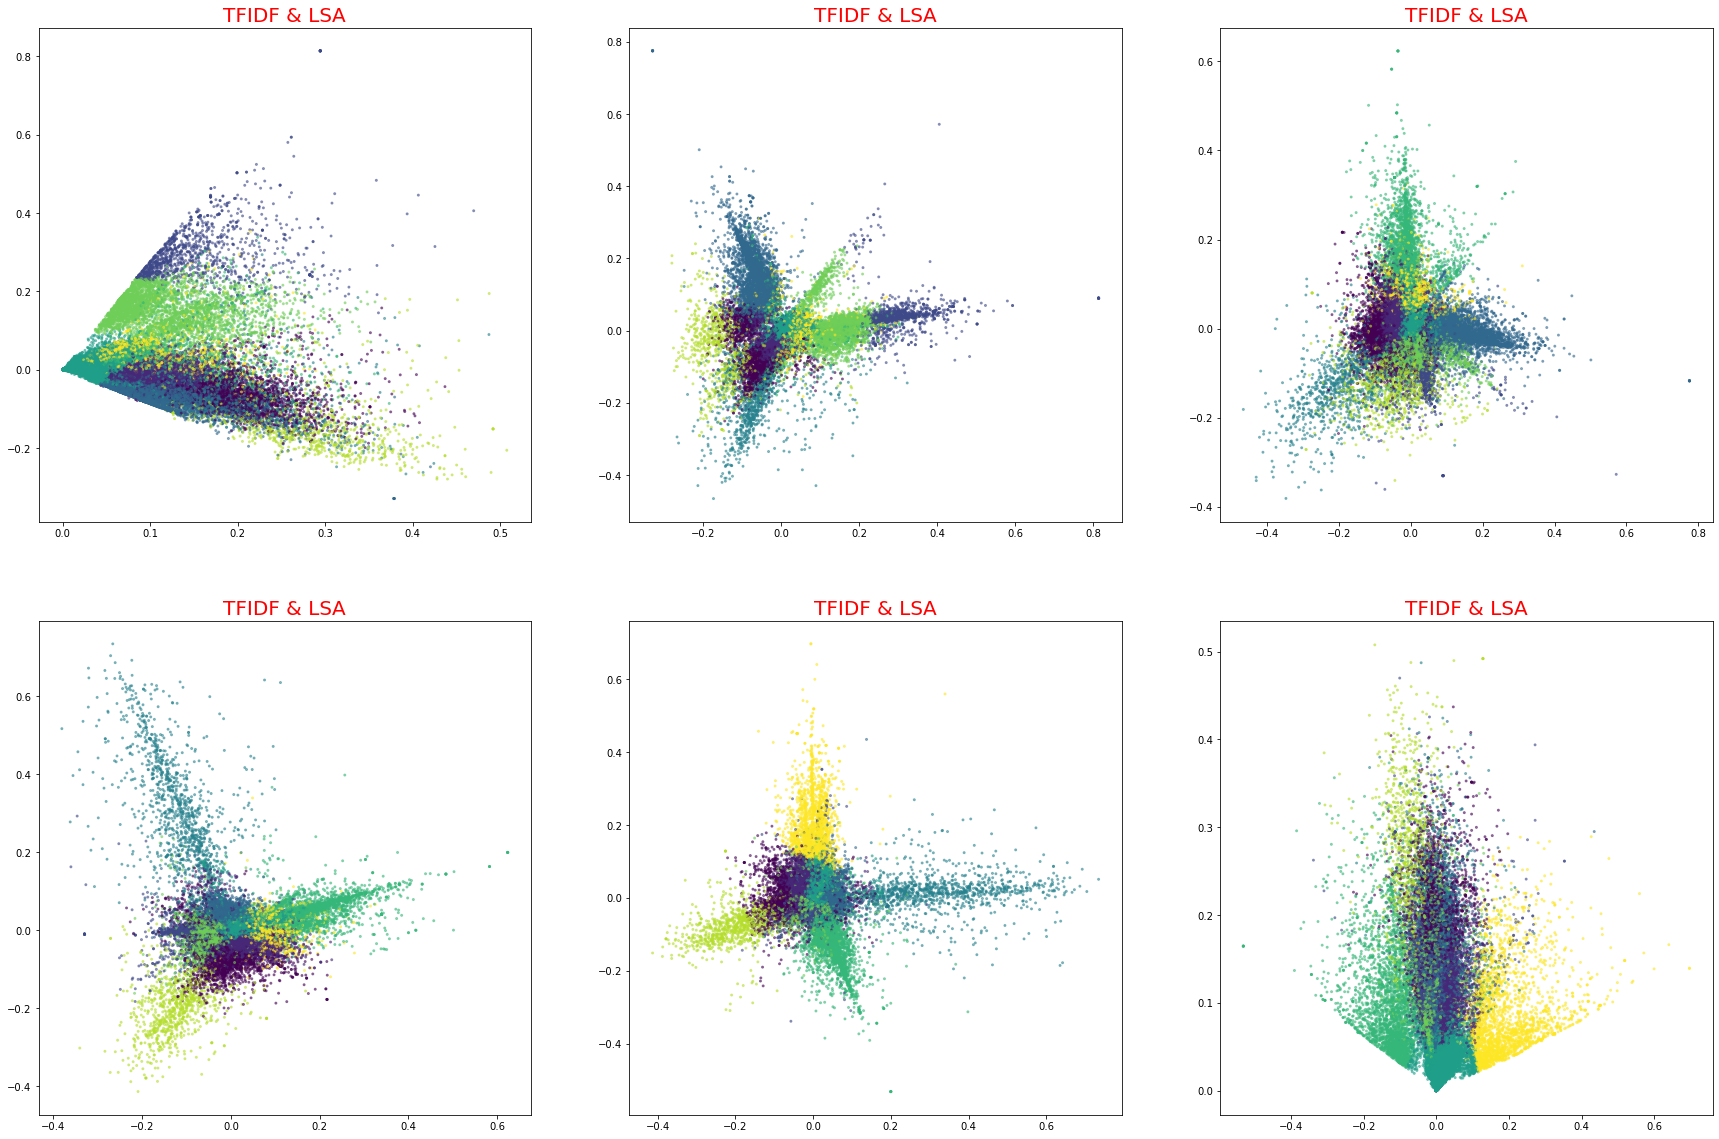

In [37]:
# --- TFIDF with LSA using 6-dim intermediate dims
model = nlp_model(vect_method = 'tfidf', dim_reduc='LSA', n_components = 6)
model.fit(data['title_clean'])
doc_dr_tfidf_lsa6 = model.doc_dr_data
kmeans = KMeans(n_clusters=10, random_state=30).fit(doc_dr_tfidf_lsa6)
kmeans_tfidf_lsa6 = kmeans.labels_

plot_all_dimensions(doc_dr_tfidf_lsa6, kmeans_tfidf_lsa6, "TFIDF & LSA")

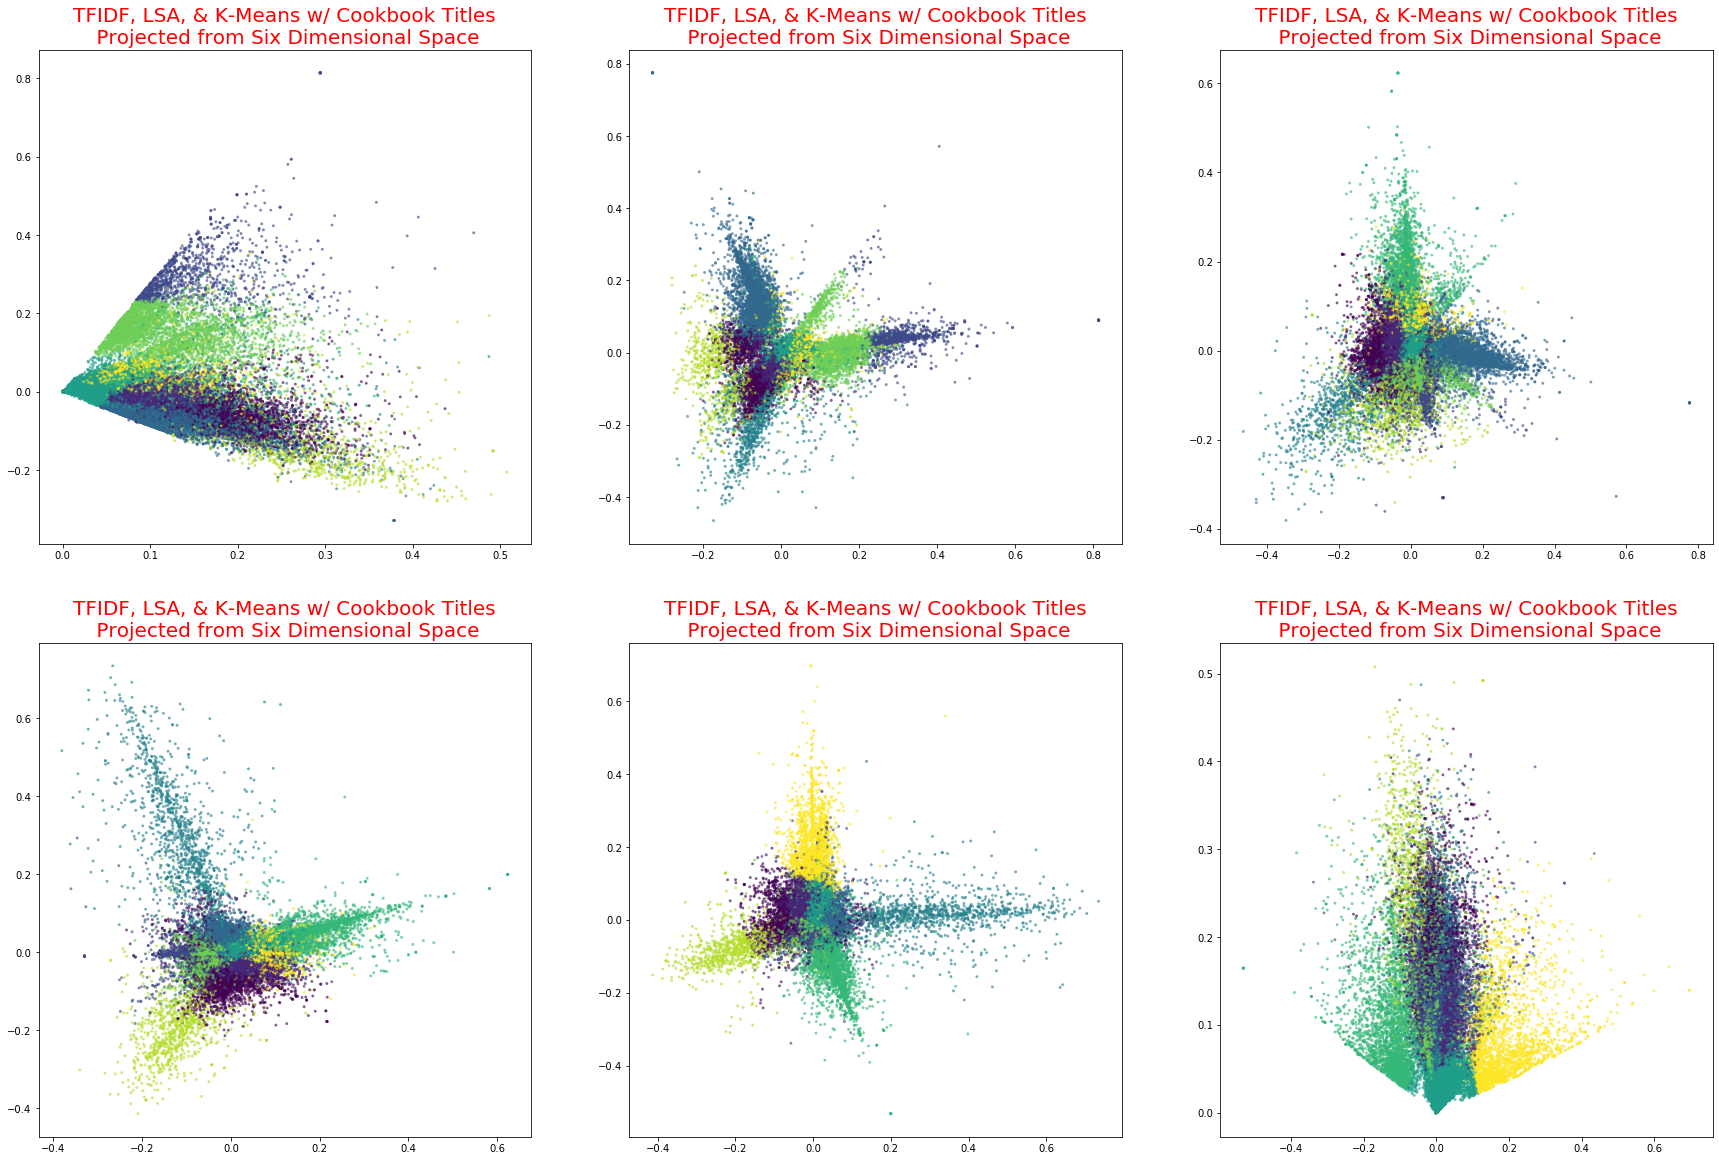

In [39]:
plot_all_dimensions(doc_dr_tfidf_lsa6, kmeans_tfidf_lsa6, "TFIDF, LSA, & K-Means w/ Cookbook Titles\n Projected from Six Dimensional Space")

In [122]:
print(data_nmfs['count_nmf'].value_counts())
data_nmfs[data_nmfs['count_nmf']==5].tail(20)

5    18385
2     9373
1     7611
0     5148
3     2772
9      706
4      301
6      238
8      197
7       72
Name: count_nmf, dtype: int64


asin                                              title  \
44798  B0145X6SQC               Bacon Love! 2016 Day-to-Day Calendar   
44799  B0147L6T2U                             Designer Handbag Cakes   
44800  B0147L5U66         The Wilton Method: Decorating with Fondant   
44801  B0147L5T2Q                         Classic Croissants at Home   
44802  B0147L8GLC     Handmade Sourdough: From Starter to Baked Loaf   
44803  B0147L882O                 A Modern Take on the Mother Sauces   
44805  B014I7GNT2  Just Time For A Quickie! (Copyright 2015) by J...   
44806  B016107TYM              The Betty Crocker Recipe Card Library   
44808  B017BZQELK  HOME COOKIN' IS A FAMILY AFFAIR, Compiled by t...   
44813  B019DKJW42  Raising the Coffee Bar, Sofia Coffee Recipe Bo...   
44814  B019FGV48G  Cook's Illustrated January/February 2016 Perfe...   
44816  B019YH086U   Old Mr. Boston DeLuxe Official Bartender's Guide   
44818  B01BQ1GIRK  Celebrations from the Heart: Giving from our F...   
44820  B01CRAXZQ6  Time 100 Healthiest Food and How to Eat Them M...   
44822  B01DWLJEMI  A Ladle of Love Recipe Book - The Descendants ...   
44825  B01FGOH0AW  The Coffee Roaster's Companion by Scott Rao (2...   
44828  B01FIYEQY8                         Eagle Brand 1-2-3 Desserts   
44829  B01FKRXBM6  Taste of Home: Appetizers: 410 Party Favorites...   
44830  B01FKUY6TU  The School of Sophisticated Drinking: An Intox...   
44832  B01FMVXYF4            Drinking in America: Our Secret History   

                                             title_clean  \
44798                  bacon love    day to day calendar   
44799                             designer handbag cakes   
44800         the wilton method  decorating with fondant   
44801                         classic croissants at home   
44802     handmade sourdough  from starter to baked loaf   
44803                 a modern take on the mother sauces   
44805  just time for a quickie   copyright    by juli...   
44806              the betty crocker recipe card library   
44808  home cookin  is a family affair  compiled by t...   
44813  raising the coffee bar  sofia coffee recipe bo...   
44814  cook s illustrated january february   perfect ...   
44816   old mr  boston deluxe official bartender s guide   
44818  celebrations from the heart  giving from our f...   
44820  time   healthiest food and how to eat them mag...   
44822  a ladle of love recipe book   the descendants ...   
44825  the coffee roaster s companion by scott rao   ...   
44828                         eagle brand       desserts   
44829  taste of home  appetizers    party favorites b...   
44830  the school of sophisticated drinking  an intox...   
44832            drinking in america  our secret history   

                                                    desc  title_count  \
44798  ['Andrews McMeel Publishing is a leading publi...            6   
44799  ['', 'Have your handbag and eat it too! Let ce...            3   
44800  ['', 'Get rolling and learn to cover round, sq...            6   
44801  ['', 'A flaky croissant fresh from the oven! P...            4   
44802  ['', 'Make artisanal sourdough your household ...            7   
44803  ['', 'Master the mother sauces at the heart of...            7   
44805  ['The Kidd Sisters have turned up the heat in ...           14   
44806              ['A delightful set of recipe cards.']            6   
44808  ["Here for your delectation is the SPECTACULAR...           17   
44813  ["Bringing the Coffeehouse Home100 Irresistibl...            9   
44814  ['Single issue magazine filled with recipes an...           13   
44816  ['Classic bartender\'s guide "Wherein are solv...            8   
44818  ['Celebrations from the Heart features a colle...           17   
44820  ['Eating healthy meals shouldnt be complicated...            9   
44822  ["This is a spiral-bound softcover book of rec...           17   
44825  ["The Coffee Roaster's Companion is the world'...            8  

In [120]:
print(data_nmfs['tfidf_nmf'].value_counts())
data_nmfs[data_nmfs['tfidf_nmf']==6].head(20)

4    14323
6     9340
9     6785
0     4384
2     3510
7     2382
3     1444
5     1206
1     1047
8      382
Name: tfidf_nmf, dtype: int64


asin                                              title  \
6   0002251337                          Balsamic Vinegar Cookbook   
8   0002250713  The Artist's Table: A Cookbook by Master Chefs...   
13  0002251280          Dinner Parties (Easy Entertaining Series)   
16  0002550857                                  The Best of Italy   
17  0002551489                                 The Best of Mexico   
20  0002553457                   Pears: A Country Garden Cookbook   
23  0002553465                  Squash: A Country Garden Cookbook   
24  0002551497                                  The Best of China   
29  0002553724                   Australia the Beautiful Cookbook   
30  000255464X  The Best of Beautiful Cookbooks: France, Italy...   
32  0002554593                 Feast for Life: A Benefit Cookbook   
33  0002554755                     The Best of Waffles & Pancakes   
34  0002551519          Pacific Northwest: The Beautiful Cookbook   
35  0002550865                                 The Best of France   
41  0002550318  France: A Culinary Journey- Classic Recipes fr...   
42  0002554747  Joachim Splichal's Patina Cookbook: Spuds, Tru...   
46  0004126815  Rose Elliot's Vegetarian Christmas: Over 150 R...   
51  0004140125           The Josceline Dimbleby Complete Cookbook   
58  0006395848                   Lesley Stowe Fine Foods Cookbook   
62  0007121172  Living Foods for Radiant Health: The Authentic...   

                                          title_clean  \
6                           balsamic vinegar cookbook   
8   the artist s table  a cookbook by master chefs...   
13          dinner parties  easy entertaining series    
16                                  the best of italy   
17                                 the best of mexico   
20                   pears  a country garden cookbook   
23                  squash  a country garden cookbook   
24                                  the best of china   
29                   australia the beautiful cookbook   
30  the best of beautiful cookbooks  france  italy...   
32                 feast for life  a benefit cookbook   
33                     the best of waffles   pancakes   
34          pacific northwest  the beautiful cookbook   
35                                 the best of france   
41  france  a culinary journey  classic recipes fr...   
42  joachim splichal s patina cookbook  spuds  tru...   
46  rose elliot s vegetarian christmas  over   rec...   
51           the josceline dimbleby complete cookbook   
58                   lesley stowe fine foods cookbook   
62  living foods for radiant health  the authentic...   

                                                 desc  title_count  count_nmf  \
6   ["An estimated 1.75 million liters of commerci...            3          0   
8   ["How would you like to dine in Van Gogh's oli...           18          0   
13  ['Dinner Parties presents 10 diverse menus for...            5          1   
16  ["This wonderful series is the easiest way to ...            4          5   
17  ["This wonderful series is the easiest way to ...            4          5   
20  ["Beautifully designed and exquisitely photogr...            5          0   
23  ['More than 40 sumptuous squash recipes -- suc...            5          0   
24  ['Great pics of food and excellent recipes. Sp...            4          5   
29  ['Each title in this award-winning series offe...            4          0   
30         ['Ships from Missouri next business day.']           11          5   
32  ["This striking, large-format cookbook, a coll...            6          0   
33  ['', 'Jane Stacey is a pastry chef and cook, a...            5          5   
34  ['Each title in this award-winning series offe...            5          0   
35  ["This wonderful series is the easiest way to ...            4          5   
41                                           ['', '']           11          2   
42  ["The first in the publisher's Great Chefs/Gre...           14